In [4]:
%load_ext autoreload
%autoreload 2


import os
import pymysql
import pandas as pd
from dotenv import load_dotenv, find_dotenv



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
env_path = find_dotenv()
load_dotenv(env_path)
#print(os.getenv('HOST'))
#print(os.getenv('USER_DB'))

True

In [3]:
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')



## Easy features

-Resources added to queue

-Resources completed from queue

-Ratio of resources added to queue to completed

-Minutes learned per year



The first three is in the queue.py file. The last is in the time_learning.py

In [4]:
df_trk = pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_res = pd.read_sql_query("SELECT * FROM resource;", conn).drop_duplicates()

df_trk_copy=df_trk.copy()
df_res_copy=df_res.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
import numpy as np
# clean track_event

# reorder the dataframe according to the userID and eventDate
df_trk=df_trk_copy
df_trk.isna().sum()/len(df_trk) #content & skipMigration have over 80% missing values, delete these columns. And drop eventID
df_trk=df_trk.iloc[1:,:-2]
#df_trk['eventType'].apply(lambda)


# reorder 
df_trk=df_trk.sort_values(by=['userID','eventDate'],ascending=[True,True]).reset_index(drop=True)
df_trk
#-------------------------------------------------------------------------------------------

# return a dataframe with userID, eventType, source,eventDate, resourceType and action
# Get queueing status (returns 1 if completed from queue)
df_trk['resourceType']=df_trk['eventType'].apply(lambda x: x.split('_')[0])
df_trk['action']=df_trk['eventType'].apply(lambda x: x.split('_')[1])
df_trk.head(20)

# Get CompletionFromQueue (returns 1 if completed from the queue)


# Get mins learned per year(make this in a different py)



#Get resourceID and source
df_src=df_trk_copy[['resourceID','source']].drop_duplicates()
# create a dataframe with userID, numOfResourcesToQueue, numOfCompletionFromQueue, RatioOfCompletion_num, minOfResourcesToQueue, minOfCompletedFromQueue, RatioOfCompletion_min
# create "isQueued" columns, returns 1 if Queued
df_trk['isQueued']=df_trk['action'].map({'queued':1}).fillna(0).astype(int)
# create "isCompleted" columns, returns 1 if Completed
df_trk['isCompleted']=df_trk['action'].map({'completed':1, 'documented':1}).fillna(0).astype(int)

df_trk=df_trk.groupby(['userID','resourceID']).sum().reset_index()
# Get CompletionFromQueue (returns 1 if completed from the queue)
df_trk['CompletedFromQueue']=((df_trk['isQueued']==1)&(df_trk['isCompleted']==1)).astype(int)


df_trk=df_trk.merge(df_src,on='resourceID')


df_trk.head(20)

# add mins from the resourceID
df_res_select=df_res[['resourceID','min']].drop_duplicates()
df_trk=df_trk.merge(df_res_select,on='resourceID')
df_trk['minQueued']=df_trk['isQueued']*df_trk['min']
df_trk['minCompleted']=df_trk['CompletedFromQueue']*df_trk['min']


# if 'specified_source=True'
df_trk1=df_trk.groupby(['userID','source']).sum().reset_index()
df_trk1.rename(columns={'isQueued':'numQueued','CompletedFromQueue':'numCompletedFromQueue'},inplace=True)


df_trk1.head()

# if 'specified_source=False'
df_trk2=df_trk1.groupby(['userID']).sum().reset_index()
df_trk2['numQueued']=df_trk2['numQueued'].replace(0,-1)
df_trk2['minQueued']=df_trk2['minQueued'].replace(0,-1)
df_trk2['RatioOfCompletion_num']=np.abs(df_trk2['numCompletedFromQueue']/df_trk2['numQueued'])
df_trk2['RatioOfCompletion_min']=np.abs(df_trk2['minCompleted']/df_trk2['minQueued'])
# drop 'min' and 'isCompleted' as unnecessary
df_trk2=df_trk2.drop(['min','isCompleted'],axis=1)
#replace -1 back to 0
df_trk2['numQueued']=df_trk2['numQueued'].replace(-1,0)
df_trk2['minQueued']=df_trk2['minQueued'].replace(-1,0)
df_trk2.head(10)
#------------------------------------------------------------------

# if 'specified_source=True'
df_trk1['numQueued']=df_trk1['numQueued'].replace(0,-1)
df_trk1['minQueued']=df_trk1['minQueued'].replace(0,-1)
df_trk1['RatioOfCompletion_num']=np.abs(df_trk1['numCompletedFromQueue']/df_trk1['numQueued'])
df_trk1['RatioOfCompletion_min']=np.abs(df_trk1['minCompleted']/df_trk1['minQueued'])
#replace -1 back to 0
df_trk1['numQueued']=df_trk1['numQueued'].replace(-1,0)
df_trk1['minQueued']=df_trk1['minQueued'].replace(-1,0)
# drop min and 'isCompleted'
df_trk1=df_trk1.drop(['min','isCompleted'],axis=1)




In [10]:
df_trk1.head(20)

,userID,source,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min
0,00001d9c-5de5-4ed2-9ecc-98341286765a,ausmed,12,0,700.0,0.0,0.000000,0.000000
1,0000c854-c7a3-4047-9a54-2e1a3464621f,ausmed,0,0,0.0,0.0,0.000000,0.000000
2,000169ca-f6bf-4ac0-a13d-c2b188014962,ausmed,0,0,0.0,0.0,0.000000,0.000000
3,0001c897-b1fe-40e0-afef-6a667edf41f7,ausmed,0,0,0.0,0.0,0.000000,0.000000
4,0002e8b5-261b-44a6-b38c-2997b4007317,ausmed,0,0,0.0,0.0,0.000000,0.000000
5,0002f0ba-44b0-44d3-a542-3be3dd4d5036,ausmed,1,0,50.0,0.0,0.000000,0.000000
6,00034f05-a97f-4dfe-8162-f83b7709b392,ausmed,0,0,0.0,0.0,0.000000,0.000000
7,00036835-5926-476a-bd8a-65c39be4e6cc,ausmed,69,1,2009.0,7.0,0.014493,0.003484
8,0003f9de-385c-45dc-9b19-31df24266aa9,ausmed,0,0,0.0,0.0,0.000000,0.000000
9,00049633-8b5c-4a00-b869-4c107f941d13,ausmed,0,0,0.0,0.0,0.000000,0.000000


## Easy Feature Min per year

Two potential resources:

-'activity_20220808' (use this)

-tracking_event

-

Two Steps:
1.create a column to get user's Ausmed year (from user AusmedYear=lastest activity date-account createDate)
2.caculate the total min

In [5]:
# check activity data
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()

df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType


def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls




# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': pd.Series.mode, '2ndFavActivityType': fav_activityType}).reset_index()


# merge with df_usr
df_act1=df_act # save a copy
df_act=df_usr[['userID','yearsOnAusmed']].merge(df_act, on='userID', how='inner')


# rename the columns
df_act.rename(columns={'activityType': 'favActivityType'},inplace=True)





# get Min learnt from Ausmed
df_act['yearsOnAusmed']=df_act['yearsOnAusmed']/ np.timedelta64(1, 'Y')
df_act['minOnAusmedPerYear']=df_act['minOnAusmed']/df_act['yearsOnAusmed']

# get percentageOfLearningFromAusmed
df_act['minPerYear']=df_act['min']/df_act['yearsOnAusmed']
df_act['percentageOfLearningFromAusmed']=df_act['minOnAusmedPerYear']/df_act['minPerYear']

# drop uneeded columns
df_act=df_act.drop(columns=['yearsOnAusmed','min','minOnAusmedPerYear'])

# drop na
df_act=df_act.dropna()

# 


In [168]:
import numpy as np
import seaborn as sns
#df_act[df_act['providerName']=='N/A']

#df_act['favActivityType'].value_counts()
df_act['minPerYear'].plot.density()

NameError: name 'df_act' is not defined

# Hidden features

## Task1: % of users compliant per year (consdier hours of CPD completed and documented, learning goals set, context of practice set)

-CPD requirement is in the "groupRegulation"

-Goal: replacing intented 

-Q: how do we define overachiver/ casual learner/ ambitious learner

In [ ]:
# clean context of practice set

#create a table return CPD record with CPD hours required, CPD completed, documented

#create a goal table with column, goals per year, number of goals achived, ratio of goals achieved, ratio of 

# make compliency() function returns 

In [ ]:
# clean context of practice set
#load the data
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn)
df_pp=pd.read_sql_query("SELECT * FROM professionalprofile;", conn).drop_duplicates()
df_wk=pd.read_sql_query("SELECT * FROM work;", conn).drop_duplicates()
df_edu=pd.read_sql_query("SELECT * FROM education;", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()



df_cop_copy=df_cop.copy()
df_pp_copy=df_pp.copy()
df_wk_copy=df_wk.copy()
df_edu_copy=df_edu.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

In [ ]:
# sneak peek 
import datetime as dt
df_cop=df_cop_copy
# df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
#        'population', 'focus', 'complex', 'autonomy', 'access', 'startDate',
#        'endDate', 'createDate', 'updateDate', 'topics', 'summary']]
#print(df_cop.columns)
#check
df_cop.isna().sum()/len(df_cop)# drop['topics', 'summary']
df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access', 'startDate',
       'endDate','createDate']]
# convert 'startDate','endDate'
#df_cop['startDate']=pd.to_datetime(df_cop['startDate'],errors='coerce')  

#df_cop[df_cop['startDate'].isna()]
df_cop.iloc[[3575,16699,29224,51510]]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'
#df_cop.iloc[[3575]]
df_cop['startDate']=pd.to_datetime(df_cop['startDate'],errors='coerce')  
df_cop['createDate']=pd.to_datetime(df_cop['createDate'],errors='raise')  
df_cop[df_cop['startDate'].isna()]

# compute gap between createDate and startDate
#df_cop['gapBetweenStartAndCreate']=df_cop['createDate']-df_cop['startDate']
df_cop.head()
median=(df_cop['createDate']-df_cop['startDate']).median()
df_cop['startDate'].fillna(value=df_cop['createDate']-median,inplace=True)
df_cop['startDate']=df_cop['startDate'].apply(lambda x: dt.datetime(x.year,x.month,x.day))
#check previsously Nat rows
df_cop.iloc[[3575,16699,29224,51510]]

# get years of experience 
## replace missing values in endDate by current date
df_cop['endDate'].fillna(value=dt.date.today(),inplace=True)
df_cop['endDate']=pd.to_datetime(df_cop['endDate'],errors='coerce')
df_cop['yearsOfExperience']=df_cop['endDate']-df_cop['startDate']
#df_cop.info()

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'

# drop 'pProfile' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfile','endDate','createDate'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))

merged_df = merged_df.loc[:, cols]
list(merged_df)

['userID',
 'pProfileID',
 'typeOfPractice',
 'located',
 'specialities',
 'population',
 'focus',
 'complex',
 'autonomy',
 'access',
 'country']

In [45]:
# main
# This table has one-to-many relationships, keep the lastest 
# return userID,typeOfPractice, located	specialities, population, focus, complex autonomy access startDate, yearsOfExperience
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn).drop_duplicates()
df_pp=df_pp_copy



# drop duplciates
df_cop = df_cop.drop_duplicates()

df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access','startDate','createDate','endDate']]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'

# drop 'pProfile' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfile'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))


merged_df = merged_df.loc[:, cols].drop_duplicates().sort_values(by=['userID','startDate'],ascending=[True,False])

# only keep the lastest
merged_df.drop_duplicates(subset=['userID'],keep='first',ignore_index=True,inplace=True)
#merged_df.head(10)

# drop "startDate, createDate, endDate" as they are no longer needed
merged_df.drop(['startDate', 'createDate', 'endDate'],axis=1)
merged_df.head(10)


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,userID,pProfileID,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,createDate,endDate,country
0,0000c854-c7a3-4047-9a54-2e1a3464621f,694b3b93-e762-427b-a1b8-72426d764a6c,private company,metropolitan centre,Perioperative Nursing,adults,clinical practice,generally complex,moderate,usually,2020-07-15,2020-07-14 21:46:21,None,AUS
1,00013cfc-f97f-428d-bf6b-558601512bd7,0bbfbfc8-5b48-4ca1-b05f-21638761d716,Other,metropolitan centre,"Immunisation,Cancer screening,General Practice",Other,nurse education,generally complex,moderate,usually,2017-06-01,2017-08-09 01:08:25,2018-05-31,AUS
2,00023498-c236-45f6-aaf1-ee382e520737,abcef1bf-aff5-45a8-b4e7-8c6a4a74a3d1,community,large rural centre,Paramedicine,adults,clinical practice,high complexity,moderate,usually,2018-12-01,2019-11-07 20:12:17,2019-11-30,AUS
3,0002f0ba-44b0-44d3-a542-3be3dd4d5036,5e540d39-66bc-422f-bd37-8b98ae0efd17,hospital,large rural centre,Surgical,adolescents or youth,clinical practice,generally complex,minimal,always,2022-02-01,2020-06-16 04:01:55,None,AUS
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,7885bef2-0959-4e88-878c-5eddb5850e1e,hospital,metropolitan centre,Intensive Care,adults,clinical practice,generally complex,moderate,always,2016-06-01,2017-02-27 20:46:37,2017-05-31,AUS
5,0008e1bc-589a-4bf3-ae16-ace555566578,ab2a1aed-322f-48b7-915d-7749ee02b65c,private practice,metropolitan centre,"Defence Nursing, GP nursing, small procedures,...",adults,clinical practice,very complex,high,always,2017-06-01,2017-06-04 12:46:32,2018-05-31,AUS
6,0009a8e2-e28f-47be-83fd-1f6d244d88c9,09f1c653-1127-43fa-a213-6b3515a8b21e,hospital,large rural centre,"Emergency,Critical Care",adults,clinical practice,very complex,moderate,always,2021-09-15,2021-05-14 04:21:07,None,AUS
7,000a1700-b302-415b-8c57-9ddcc1b61599,38bccb57-b74a-4cbf-9953-3879596b5e97,hospital,capital city,Clinical Nurse Specialist,Safety & Quality,management,be generally complex,moderate,always,2016-06-01,2016-10-17 23:16:22,2017-05-31,AUS
8,000a1b0d-5b7e-4ae1-a5a0-6fccab0c7559,e1c13c21-c769-4993-83b2-058373ce57d7,hospital,large rural centre,Orthopaedics,adults,clinical practice,generally complex,moderate,usually,2021-06-19,2021-06-18 22:28:44,None,AUS
9,000af191-1389-4cba-900e-e4a87debc02d,0da7e697-cef6-4493-a348-1160321ce2fe,hospital,capital city,Anaesthetic Nurse,children,clinical practice,generally complex,moderate,always,2018-04-23,2021-06-03 08:15:01,None,AUS


# Hidden Feature 

## Task 2: learning goals set

-learning goals set

-Goals set per year

In [166]:
# download relevent data
df_goal=pd.read_sql_query("SELECT * FROM goal;", conn).drop_duplicates()
df_gcs=pd.read_sql_query("SELECT * FROM goalCompetencyStandard;", conn).drop_duplicates()
df_grr=pd.read_sql_query("SELECT * FROM groupRegulation;", conn).drop_duplicates()

df_goal_copy=df_goal.copy()
df_gcs_copy=df_gcs.copy()
df_grr_copy=df_grr.copy()


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [167]:
df_goal.head()

,goalID,owner,title,startDate,endDate,startDateLocal,endDateLocal,topics,priority,isAchieved,publicGoal,qualifications,intendedMin,completedMin,relatedActivityNum,createDate,updateDate,achieveDate,orgID
0,00005d58-bb42-4b39-b412-a665efbbb512,e970fb89-6e51-4da5-a578-45c64e3c04fd,Everything,2021-05-31 14:00:00,2022-05-31 13:59:59,2021-06-01,2022-05-31,None,3.0,0,None,None,NaN,0.0,0.0,2021-05-31 23:20:18,2021-05-31 23:20:18,NaT,None
1,00015df6-b936-4f1b-8d9c-1b4759f78ba7,9629fc28-f907-4273-9a70-46777969bdb8,To settle into working for a new organisation ...,2016-05-31 04:00:00,2016-06-01 03:59:59,2016-06-01,2016-06-01,None,1.0,0,None,None,NaN,0.0,0.0,2018-05-06 22:59:36,2018-05-06 22:59:56,NaT,None
2,0001ddc3-f649-4a15-9bfb-81a00146d0b3,567120d7-eee6-4a3b-87f8-aaaa38f8b4e4,4 year old healthy kids check,2014-09-10 14:00:00,2014-10-11 12:59:59,None,None,352990e1-c115-4e9f-9f85-f83bcee39f48,1.0,1,None,b03680d4-c726-4a19-85c4-7f2fb9f20674,180.0,150.0,1.0,2014-09-11 04:06:57,2015-01-21 02:01:13,2015-01-21 02:01:13,None
3,00028225-a41b-407e-af66-b3660b92d8ce,5ec5104d-513b-4cfb-9a7b-fd62bd74d2dd,Complete mandatory training\nImprove my triage...,2019-05-31 04:00:00,2020-05-31 03:59:59,2019-06-01,2020-05-31,None,1.0,0,None,None,NaN,0.0,0.0,2020-01-29 23:18:09,2020-01-29 23:18:09,NaT,None
4,00030114-1484-4004-a148-74a1536767b2,0f88ad4e-35fe-4f2f-a237-f292dd805d16,"By the end of the CPD year, I will update and ...",2020-05-31 14:00:00,2021-05-31 13:59:59,2020-06-01,2021-05-31,None,3.0,0,None,None,NaN,97.0,2.0,2021-05-12 06:15:05,2021-05-12 06:15:23,NaT,None


# Baseline Model

Let's pipe line up!

Preprocessing: 
- basic scaling all numerical features

- do not use favActivityType, come back later!


- MiniBatichKmeans: play around with the number of clusters

In [6]:
from customerclustering.db_connection import Db
from customerclustering.get_training_data import *

In [8]:
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')




rows=200000
df=GetTrainingData(conn,rows).get_training_data()
df_copy=df
df.head()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,2ndFavActivityType,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff
0,Ausmed Subscription,incomplete_expired,b844dd04-799b-4d74-aa89-e3d91e6b135b,cus_CwbLsaFBPovaL4,14,1541.0,af363c96-f975-4999-aba0-494e9ec28f17,hospital,capital city,Paediatrics,...,[e-Learning],71.225027,1.000000,40,0,1904.0,0.0,0.000000,0.000000,27.220065
1,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1612.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,[e-Learning],488.745088,0.201299,8,0,442.0,0.0,0.000000,0.000000,117.197044
2,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1232.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,[e-Learning],533.493207,1.000000,4,0,228.0,0.0,0.000000,0.000000,164.064103
3,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2121.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,[e-Learning],48.543769,0.226415,9,1,492.0,35.0,0.111111,0.071138,149.362205
4,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1944.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,[e-Learning],10.512799,1.000000,46,2,1909.0,25.0,0.043478,0.013096,76.311787


In [9]:
df.describe()

,num_subs,account_age,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff
count,7791.000000,7791.000000,7.791000e+03,7791.000000,7791.000000,7791.000000,7791.000000,7791.000000,7791.000000,7791.000000,7791.000000
mean,1.116545,1477.036067,3.760924e+06,0.487622,16.750225,0.378899,771.009626,9.764343,0.026551,0.016620,141.199186
std,0.437958,487.239885,1.976841e+08,0.446115,20.815517,1.179711,932.834107,40.104810,0.093115,0.078444,77.107343
min,1.000000,177.000000,-9.141643e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081633
25%,1.000000,1098.000000,2.934038e+01,0.000000,3.000000,0.000000,121.000000,0.000000,0.000000,0.000000,79.963684
50%,1.000000,1584.000000,7.511973e+01,0.383562,10.000000,0.000000,457.000000,0.000000,0.000000,0.000000,139.196000
75%,1.000000,1930.000000,2.121297e+02,1.000000,23.000000,0.000000,1109.000000,0.000000,0.000000,0.000000,196.566528
max,14.000000,2125.000000,1.704075e+10,1.000000,366.000000,26.000000,12396.000000,1247.000000,1.000000,1.000000,362.000000


In [143]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')

# reindex df
df=df_copy
#df=df.set_index('userID')

# select columns
# use all numerical columns
num_col=df.describe().columns
# Do not use favActivityType 
cat_col=['Product', 'Status','typeOfPractice', 'located',
       'specialities', 'population', 'focus', 'complex', 'autonomy', 'access','country']
df['complex'].nunique()

# Robustscaler all numerical columns
num_transformer=RobustScaler()

#LabelEncoder all categorical columns
cat_transformer=LabelEncoder()


# Our first base pipeline-doesn;t work
preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_col))



# manually transform the numerical and categorical columns
## numerical
df_num=pd.DataFrame(num_transformer.fit_transform(df[num_col]))
df_num.columns=num_col
df_num.head()

## categorical
df_cat=df[cat_col].apply(cat_transformer.fit_transform)

df_processed=df_num
df_processed[cat_col]=df_cat
df_processed.head()

# reindex df by userID
df_processed.set_index(df['userID'],inplace=True)
df_processed

#basepipe=make_pipeline(preproc,MiniBatchKMeans()) #shame on you!

#basepipe

,Product,Status,num_subs,account_age,typeOfPractice,located,specialities,population,focus,complex,...,access,country,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min
userID,,,,,,,,,,,,,,,,,,,,,
b844dd04-799b-4d74-aa89-e3d91e6b135b,2,2,13.0,-0.051683,490,0,2658,498,458,4,...,0,1,-0.021307,0.616438,1.50,0.0,1.464575,0.0,0.000000,0.000000
6037d38d-d098-4f68-be8c-49b7131b8116,2,2,9.0,0.033654,490,3,3198,467,458,2,...,0,1,2.262853,-0.182263,-0.10,0.0,-0.015182,0.0,0.000000,0.000000
62d1fe96-34f6-4992-9f15-b240f07770d8,2,1,8.0,-0.423077,490,1,112,464,488,2,...,2,1,2.507660,0.616438,-0.30,0.0,-0.231781,0.0,0.000000,0.000000
6e6b0e01-4a29-4724-a781-5d6a0d72a213,2,1,5.0,0.645433,127,2,1792,467,470,2,...,0,1,-0.145391,-0.157147,-0.05,1.0,0.035425,35.0,0.111111,0.071138
33d2881f-8bc6-4b98-bafe-bfd20b141ee2,2,0,4.0,0.432692,490,2,3865,467,451,2,...,0,1,-0.353450,0.616438,1.80,2.0,1.469636,25.0,0.043478,0.013096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffded699-79d7-4e0d-82d9-c30117a0ad1b,2,1,0.0,0.370192,478,2,3814,519,458,2,...,0,1,-0.068671,-0.383562,-0.25,0.0,-0.199393,0.0,0.000000,0.000000
ffea3abb-35aa-42fc-9f58-c76d98abd90c,2,1,0.0,0.175481,490,2,1236,467,458,6,...,0,1,0.638914,-0.383562,-0.15,3.0,-0.134615,131.0,0.428571,0.404321
ffef04f1-35a5-4af4-95ed-8ac18a6b1ceb,3,1,0.0,0.348558,490,1,3356,467,458,2,...,0,1,1.416740,0.616438,0.05,0.0,0.226721,0.0,0.000000,0.000000


### Use Elbow Method to find the optimal cluster size

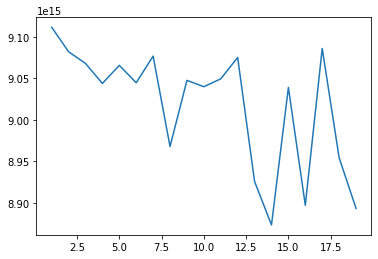

In [144]:
import matplotlib.pyplot as plt
# find the optimal n_cluster
X=df_processed
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(X).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss)

Looks like the optimal number of cluster is around 14, but should we go that far? Maybe 8 is enough?

# Visualization of the Basemodel Output

In [148]:
# The baseline model
print(f"The optimal cluster size is {clusters[wcss.index(min(wcss))]}") # this gives 14
n_cluster=14
base_model=MiniBatchKMeans(n_clusters=14)
X_pred=base_model.fit(df_processed).predict(df_processed)


The optimal cluster size is 14


In [153]:
# get centers
df_centers=pd.DataFrame(base_model.cluster_centers_)
df_centers.columns=df_processed.columns
df_centers.describe()

,Product,Status,num_subs,account_age,typeOfPractice,located,specialities,population,focus,complex,...,access,country,minPerYear,percentageOfLearningFromAusmed,numQueued,numCompletedFromQueue,minQueued,minCompleted,RatioOfCompletion_num,RatioOfCompletion_min
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,2.184208,0.528801,0.382326,-0.161127,456.659772,1.758413,2382.066387,463.038125,423.196525,3.506891,...,0.927464,1.002796,37327.091276,0.100274,0.358125,0.373218,0.340164,8.108384,0.032073,0.015239
std,0.131143,0.257571,1.150782,0.314573,69.952722,0.322707,940.586897,40.759391,70.873652,0.866357,...,0.442422,0.003813,138463.675469,0.206673,0.487515,0.250091,0.522114,4.568838,0.029718,0.007230
min,2.014742,0.122850,0.022255,-1.007347,237.211302,1.113320,307.976776,334.375410,250.270270,2.186732,...,0.131783,1.000000,0.195999,-0.201838,-0.367959,0.023256,-0.336848,0.509044,0.004675,0.003283
25%,2.115805,0.365357,0.044214,-0.264831,468.529188,1.646161,2210.906903,456.330710,445.197184,3.040027,...,0.570608,1.000000,1.933602,-0.046778,0.113391,0.236598,0.101005,5.993493,0.015641,0.010660
50%,2.187053,0.497328,0.090928,-0.147329,484.483720,1.752283,2542.260851,467.046050,450.471183,3.418717,...,0.941373,1.000567,4.715137,0.094260,0.301934,0.315181,0.284103,8.086214,0.022610,0.014684
75%,2.212926,0.634417,0.110450,-0.034699,488.459953,1.918805,2994.794181,485.355775,454.688926,3.814751,...,1.206682,1.004632,15.263857,0.226199,0.434867,0.396048,0.397845,9.337758,0.031506,0.020544
max,2.577049,1.022863,4.378728,0.432515,507.679412,2.421365,3652.610765,506.440196,457.454098,5.679587,...,1.837838,1.010714,518389.725444,0.532453,1.782344,0.891892,1.930485,20.464706,0.104181,0.029224


Text(0.5, 0.92, 'simple 3D scatter plot')

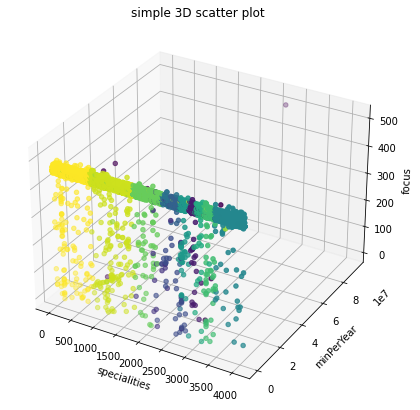

In [156]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Choose the columns have large std from the describe table
x=df_processed.specialities
y=df_processed.minPerYear
z=df_processed.focus

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('specialities')
ax.set_ylabel('minPerYear')
ax.set_zlabel('focus')
plt.title("simple 3D scatter plot")

In [ ]:
df_processed

# Clean Favorite ActiveityType

In [39]:
from customerclustering.learning import *

df_lrn_2=Learning()

NameError: name 'Lea' is not defined

In [38]:
import numpy as np
df_act=df_act_copy
# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType
import random #yep Ran so random

def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls

# to handle multiple mode
def fav_fav(series): 
    mode=series.mode()
    if len(mode)==1:
        return mode
    else: 
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]
        #return random.shuffle(mode)[0]


# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': fav_fav, '2ndFavActivityType': fav_activityType}).reset_index()
#mode=df_act['activityType'].mode()
#fav_fav(df_act['activityType'])

0    Competency
1    Conference
Name: activityType, dtype: object
0    Competency
1    e-Learning
Name: activityType, dtype: object
0    Conference
1    In-Service
2    e-Learning
Name: activityType, dtype: object
0    Competency
1      Textbook
Name: activityType, dtype: object
0    In-Service
1      Teaching
Name: activityType, dtype: object
0    In-Service
1    e-Learning
Name: activityType, dtype: object
0    In-Service
1    e-Learning
Name: activityType, dtype: object
0      Textbook
1    e-Learning
Name: activityType, dtype: object
0    Competency
1         Other
2    e-Learning
Name: activityType, dtype: object
0      Textbook
1    e-Learning
Name: activityType, dtype: object
0    Competency
1    In-Service
2         Other
Name: activityType, dtype: object
0    In-Service
1      Textbook
Name: activityType, dtype: object
0    In-Service
1    e-Learning
Name: activityType, dtype: object
0    Competency
1    In-Service
Name: activityType, dtype: object
0    In-Service
1      Textb

In [34]:
len(mode)

1

array(['e-Learning'], dtype=object)

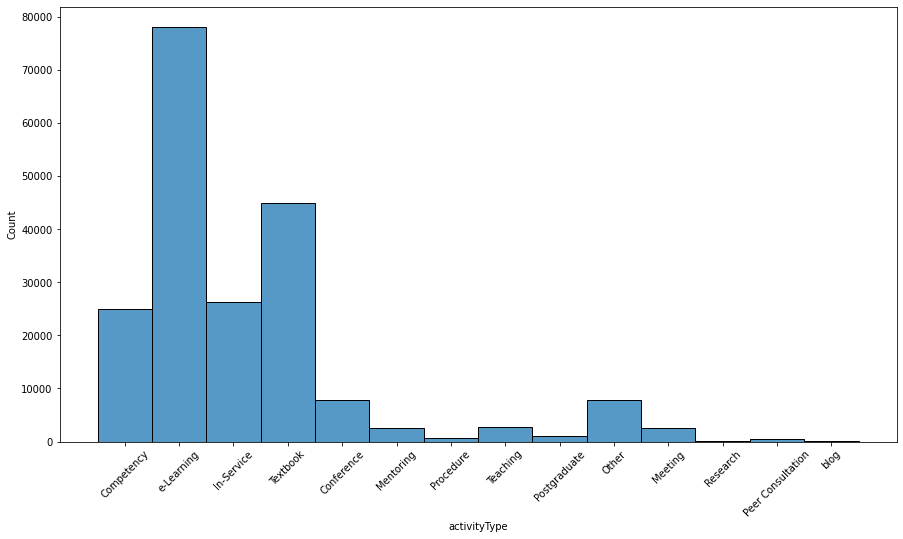

In [22]:
# exploring the distribution of activityType
import matplotlib.pyplot as plt
import seaborn as sns
df_act=df_act_copy
plt.figure(figsize = (15,8))
ax =sns.histplot(df_act['activityType'])
plt.xticks(rotation=45)



In [ ]:
#